# **라이브러리 설치**

In [36]:
!pip3 install konlpy
!pip install wordcloud

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from konlpy.tag import Okt
from konlpy.tag import Twitter
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

# **EDA 및 전처리**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/steam.csv')
df.head(10)

,Label,Review
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
5,1,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^
6,1,재미있었습니다.
7,1,은근 쉽지만 은근 어려운 게임
8,0,베ㅈ스다 이 개^ㅐ끼들아. 시작할 때 체스판 돌아가는거 5분동안 3번 봤더나 ㅈㄴ ...
9,1,1시간 40분동안 스트레스 다 풀림 ㄹㅇ


In [6]:
df.dtypes

Label      int64
Review    object
dtype: object

In [7]:
pd.DataFrame(df.isnull().sum(), columns=["결측치 개수"]) #결측치 확인

,결측치 개수
Label,0
Review,0


In [8]:
df.shape

(100000, 2)

In [9]:
df = df.drop_duplicates() #중복 데이터 삭제
df.shape

(99942, 2)

In [10]:
df['Label'].value_counts()

0    49976
1    49966
Name: Label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'data label distribution')

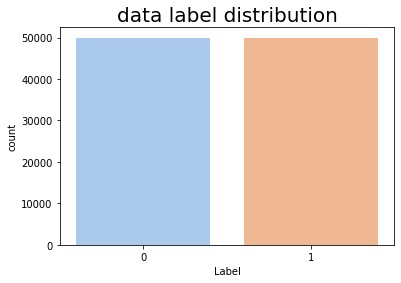

In [11]:
sns.countplot(df['Label'], palette='pastel')
fig = plt.gcf()
fig.set_size = (20, 10)
plt.title('data label distribution', size = 20)

**0 = 부정**

**1 = 긍정**

데이터 편중 현상이 발견되지 않아 조정이 필요해 보이지 않습니다.

# **학습을 위한 텍스트 전처리 과정**

In [12]:
df[:5]

,Label,Review
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [13]:
df['Review'] = df['Review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['Review'] = df['Review'].str.replace('^ +', "") # space data를 empty value로 변경
df[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Label,Review
0,0,노래가 너무 적음
1,0,돌겠네 진짜 황숙아 어크 공장 그만 돌려라 죽는다
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악차악차악 정말 이래서 왕국을 되찾을 수 있는거야
4,1,시간 때우기에 좋음 도전과제는 시간이면 다 깰 수 있어요


# **Okt 를 이용한 토큰화 진행**

In [14]:
stopwords = [] # 불용어 지정하지 않고 단어 분포 확인

In [15]:
okt = Okt() 

df['tokens'] = df['Review'].apply(okt.morphs)
df['tokens'] = df['tokens'].apply(lambda x: [i for i in x if i not in stopwords])

In [16]:
negative = np.hstack(df[df.Label == 0]['tokens'].values)
positive = np.hstack(df[df.Label == 1]['tokens'].values)

In [17]:
negative_counts = Counter(negative)
print(negative_counts.most_common(10))

[('이', 27443), ('게임', 22725), ('가', 13606), ('을', 11069), ('에', 10730), ('도', 9532), ('은', 8572), ('는', 7060), ('를', 5835), ('들', 5571)]


In [18]:
positive_counts = Counter(positive)
print(positive_counts.most_common(10))

[('이', 25402), ('게임', 22505), ('을', 12088), ('가', 11998), ('에', 10468), ('은', 7923), ('도', 7824), ('의', 7579), ('를', 6964), ('는', 6904)]


**불용어 추가가 불가피해 보입니다. 추가해보고 다시 결과를 확인해 보겠습니다.**

In [21]:
stopwords = ['로','으로','의','이', '는', '하', '게임','고','다','가',
             '을','를','는','은','도','에','지','한','듯','과','와',
             '듯','들','임','게','겜','되','음','하','네'] # 불용어 지정

In [22]:
df['tokens'] = df['tokens'].apply(lambda x: [i for i in x if i not in stopwords])

In [23]:
negative = np.hstack(df[df.Label == 0]['tokens'].values)
positive = np.hstack(df[df.Label == 1]['tokens'].values)

In [24]:
negative_counts = Counter(negative)
print(negative_counts.most_common(10))

[('안', 5377), ('너무', 4608), ('만', 4204), ('못', 4151), ('하고', 3408), ('할', 3187), ('개', 3028), ('시간', 2926), ('적', 2889), ('그냥', 2888)]


In [25]:
positive_counts = Counter(positive)
print(positive_counts.most_common(10))

[('할', 3592), ('플레이', 3552), ('만', 3514), ('시간', 3225), ('입니다', 3173), ('것', 3102), ('적', 3065), ('너무', 3019), ('하는', 3018), ('추천', 3003)]


# **Word cloud로 부정적인 리뷰와 긍정적인 리뷰의 특징을 살펴보겠습니다.**

In [26]:
is_negative = df['Label'] == 0
negative = df[is_negative]
negative.head()

,Label,Review,tokens
0,0,노래가 너무 적음,"[노래, 너무, 적음]"
1,0,돌겠네 진짜 황숙아 어크 공장 그만 돌려라 죽는다,"[돌겠네, 진짜, 황숙, 아, 어크, 공장, 그만, 돌려라, 죽는다]"
8,0,베ㅈ스다 이 개ㅐ끼들아 시작할 때 체스판 돌아가는거 분동안 번 봤더나 ㅈㄴ 빡치네 ...,"[베, ㅈ, 스, 개, ㅐ, 끼, 아, 시작, 할, 때, 체스판, 돌아가는거, 분동..."
10,0,걍 겜임 계정을 못만들어 미친겜,"[걍, 겜임, 계정, 못, 만들어, 미친]"
11,0,관람객 호랑이 불가,"[관람객, 호랑이, 불가]"


In [27]:
is_positive = df['Label'] == 1
positive = df[is_positive]
positive.head()

,Label,Review,tokens
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험판, 막노동, 하는, 사람, 인데, 장비, 내, 사야, 돼, 뭐]"
3,1,차악차악차악 정말 이래서 왕국을 되찾을 수 있는거야,"[차악차악차악, 정말, 이래서, 왕국, 되찾을, 수, 있는거야]"
4,1,시간 때우기에 좋음 도전과제는 시간이면 다 깰 수 있어요,"[시간, 때우기에, 좋음, 도전, 과제, 시간, 이면, 깰, 수, 있어요]"
5,1,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요,"[역시, 재미있네요, 전작, 에서, 할수, 없었던, 자유로운, 덱, 빌딩, 좋네요]"
6,1,재미있었습니다,[재미있었습니다]


In [28]:
okt = Okt()
twitter = Twitter()

negative_word = []
negative_word = negative['Review'].dropna()

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


**형태소 분리**

In [29]:
sentences_tag = []

for sentence in negative_word:
    morph = twitter.pos(sentence)
    sentences_tag.append(morph)

In [30]:
sentences_tag[:1]

[[('노래', 'Noun'), ('가', 'Josa'), ('너무', 'Adverb'), ('적음', 'Verb')]]

**명사 추출**

In [31]:
noun_list = []
for sentence in sentences_tag:
    for word, tag in sentence:
        if tag in ["Noun"]:
            noun_list.append(word)

In [32]:
noun_list[:5]

['노래', '진짜', '황숙', '어크', '공장']

In [33]:
noun_list = [n for n in noun_list if len(n) > 1]
noun_list[:10] #두 글자 이상 단어만 추출

['노래', '진짜', '황숙', '어크', '공장', '시작', '체스판', '분동', '진짜', '무한']

In [34]:
counts = Counter(noun_list)
tags = counts.most_common(100)
tags

[('게임', 22725),
 ('시간', 2926),
 ('그냥', 2805),
 ('플레이', 2663),
 ('사람', 2419),
 ('버그', 2361),
 ('재미', 2252),
 ('진짜', 2186),
 ('환불', 2124),
 ('스토리', 1865),
 ('생각', 1820),
 ('추천', 1802),
 ('실행', 1745),
 ('그래픽', 1495),
 ('정도', 1433),
 ('서버', 1401),
 ('노잼', 1294),
 ('시발', 1246),
 ('멀티', 1239),
 ('처음', 1232),
 ('별로', 1225),
 ('정말', 1206),
 ('하나', 1195),
 ('구매', 1191),
 ('조작', 1139),
 ('존나', 1137),
 ('계속', 1131),
 ('때문', 1106),
 ('진행', 1097),
 ('쓰레기', 1095),
 ('느낌', 1082),
 ('시작', 1068),
 ('다시', 1047),
 ('사지', 961),
 ('자체', 948),
 ('병신', 930),
 ('이건', 851),
 ('무료', 841),
 ('친구', 829),
 ('유저', 803),
 ('화면', 800),
 ('오류', 790),
 ('엔딩', 783),
 ('한글', 780),
 ('지금', 764),
 ('문제', 757),
 ('패치', 756),
 ('스팀', 751),
 ('업데이트', 751),
 ('모드', 742),
 ('망겜', 721),
 ('난이도', 713),
 ('평가', 710),
 ('새끼', 694),
 ('무슨', 677),
 ('반복', 674),
 ('보고', 666),
 ('퍼즐', 650),
 ('한번', 649),
 ('가격', 633),
 ('전투', 627),
 ('컨텐츠', 616),
 ('최적화', 614),
 ('캐릭터', 606),
 ('다른', 606),
 ('이상', 604),
 ('도전', 603),
 ('해도', 600),
 ('절

# **부정적인 리뷰 단어 특징**

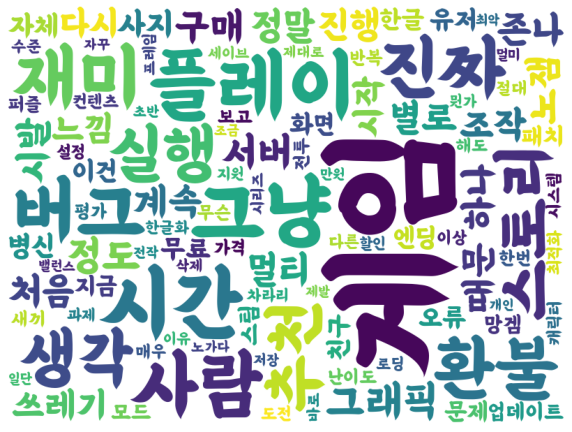

In [38]:
wordcloud = WordCloud(font_path="/content/drive/MyDrive/BMEULJIROTTF.ttf",
                     background_color='white',width=800, height=600)
#print(dict(tags))

cloud = wordcloud.generate_from_frequencies(dict(tags))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

# **긍적적인 리뷰 단어 특징**

In [39]:
positive_word = []
positive_word = positive['Review'].dropna()

In [40]:
sentences_tag1 = []

for sentence in positive_word:
    morph = twitter.pos(sentence)
    sentences_tag1.append(morph)

In [41]:
sentences_tag1[:1]

[[('막노동', 'Noun'),
  ('체험판', 'Noun'),
  ('막노동', 'Noun'),
  ('하는', 'Verb'),
  ('사람', 'Noun'),
  ('인데', 'Josa'),
  ('장비', 'Noun'),
  ('를', 'Josa'),
  ('내', 'Noun'),
  ('가', 'Josa'),
  ('사야', 'Verb'),
  ('돼', 'Verb'),
  ('뭐', 'Noun'),
  ('지', 'Josa')]]

In [42]:
noun_list1 = []
for sentence in sentences_tag1:
    for word, tag in sentence:
        if tag in ["Noun"]:
            noun_list1.append(word)

In [43]:
noun_list1[:5]

['막노동', '체험판', '막노동', '사람', '장비']

In [44]:
noun_list1 = [n for n in noun_list1 if len(n) > 1]
noun_list1[:10] #두 글자 이상 단어만 추출

['막노동', '체험판', '막노동', '사람', '장비', '차악차악차악', '정말', '왕국', '시간', '도전']

In [45]:
counts1 = Counter(noun_list1)
tags1 = counts1.most_common(100)
tags1

[('게임', 22505),
 ('플레이', 3552),
 ('시간', 3225),
 ('추천', 3003),
 ('생각', 2444),
 ('스토리', 2415),
 ('재미', 2391),
 ('사람', 2292),
 ('정말', 2141),
 ('친구', 1669),
 ('그래픽', 1578),
 ('진짜', 1502),
 ('정도', 1490),
 ('난이도', 1352),
 ('그냥', 1290),
 ('느낌', 1226),
 ('퍼즐', 1200),
 ('엔딩', 1146),
 ('처음', 1129),
 ('도전', 1117),
 ('하나', 1075),
 ('시리즈', 999),
 ('최고', 984),
 ('조금', 981),
 ('한번', 967),
 ('과제', 953),
 ('무료', 950),
 ('멀티', 943),
 ('매우', 924),
 ('모드', 862),
 ('구매', 861),
 ('가격', 837),
 ('한글', 821),
 ('한글화', 797),
 ('캐릭터', 791),
 ('다시', 773),
 ('때문', 758),
 ('버그', 757),
 ('지금', 742),
 ('단점', 735),
 ('시작', 726),
 ('자체', 706),
 ('스팀', 703),
 ('다만', 702),
 ('할인', 675),
 ('명작', 671),
 ('보고', 647),
 ('계속', 647),
 ('나름', 639),
 ('다른', 630),
 ('영어', 614),
 ('액션', 605),
 ('꿀잼', 599),
 ('타임', 598),
 ('요소', 597),
 ('아주', 583),
 ('작품', 563),
 ('조작', 562),
 ('라면', 559),
 ('패치', 557),
 ('개인', 550),
 ('진행', 538),
 ('존나', 530),
 ('클리어', 530),
 ('지원', 528),
 ('한국어', 528),
 ('분위기', 528),
 ('부분', 527),
 ('유저', 520),
 (

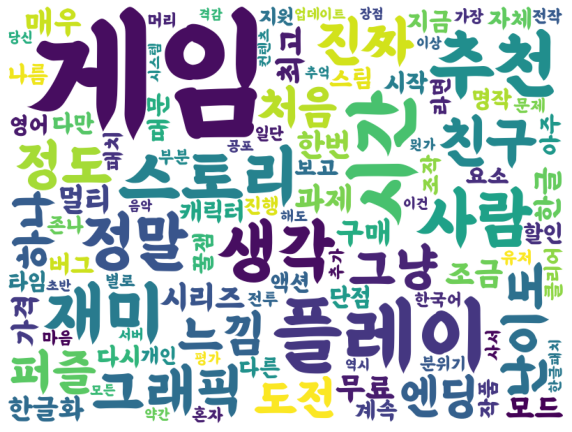

In [46]:
wordcloud1 = WordCloud(font_path="/content/drive/MyDrive/BMEULJIROTTF.ttf",
                     background_color='white',width=800, height=600)
#print(dict(tags1))

cloud1 = wordcloud1.generate_from_frequencies(dict(tags1))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud1)
plt.show()

# **분석에 도움이 되지 않는 단어, 긍/부정 공통적으로 많이 포함된 단어 제거**

In [59]:
remove_word = {'게임','진짜','사람','그냥','시간','플레이','재미','스토리','생각','추천','그래픽','때문','정도'}
noun_list = [i for i in noun_list if i not in remove_word]
noun_list1 = [i for i in noun_list1 if i not in remove_word]

In [60]:
counts = Counter(noun_list)
tags = counts.most_common(100)
tags

[('버그', 2361),
 ('환불', 2124),
 ('실행', 1745),
 ('서버', 1401),
 ('노잼', 1294),
 ('시발', 1246),
 ('멀티', 1239),
 ('처음', 1232),
 ('별로', 1225),
 ('정말', 1206),
 ('하나', 1195),
 ('구매', 1191),
 ('조작', 1139),
 ('존나', 1137),
 ('계속', 1131),
 ('진행', 1097),
 ('쓰레기', 1095),
 ('느낌', 1082),
 ('시작', 1068),
 ('다시', 1047),
 ('사지', 961),
 ('자체', 948),
 ('병신', 930),
 ('이건', 851),
 ('무료', 841),
 ('친구', 829),
 ('유저', 803),
 ('화면', 800),
 ('오류', 790),
 ('엔딩', 783),
 ('한글', 780),
 ('지금', 764),
 ('문제', 757),
 ('패치', 756),
 ('스팀', 751),
 ('업데이트', 751),
 ('모드', 742),
 ('망겜', 721),
 ('난이도', 713),
 ('평가', 710),
 ('새끼', 694),
 ('무슨', 677),
 ('반복', 674),
 ('보고', 666),
 ('퍼즐', 650),
 ('한번', 649),
 ('가격', 633),
 ('전투', 627),
 ('컨텐츠', 616),
 ('최적화', 614),
 ('캐릭터', 606),
 ('다른', 606),
 ('이상', 604),
 ('도전', 603),
 ('해도', 600),
 ('절대', 593),
 ('매우', 590),
 ('시스템', 583),
 ('설정', 583),
 ('차라리', 580),
 ('뭔가', 573),
 ('수준', 554),
 ('과제', 552),
 ('한글화', 547),
 ('할인', 543),
 ('시리즈', 529),
 ('지원', 520),
 ('프레임', 511),
 ('로딩', 508),
 (

In [61]:
counts1 = Counter(noun_list1)
tags1 = counts1.most_common(100)
tags1

[('정말', 2141),
 ('친구', 1669),
 ('난이도', 1352),
 ('느낌', 1226),
 ('퍼즐', 1200),
 ('엔딩', 1146),
 ('처음', 1129),
 ('도전', 1117),
 ('하나', 1075),
 ('시리즈', 999),
 ('최고', 984),
 ('조금', 981),
 ('한번', 967),
 ('과제', 953),
 ('무료', 950),
 ('멀티', 943),
 ('매우', 924),
 ('모드', 862),
 ('구매', 861),
 ('가격', 837),
 ('한글', 821),
 ('한글화', 797),
 ('캐릭터', 791),
 ('다시', 773),
 ('버그', 757),
 ('지금', 742),
 ('단점', 735),
 ('시작', 726),
 ('자체', 706),
 ('스팀', 703),
 ('다만', 702),
 ('할인', 675),
 ('명작', 671),
 ('보고', 647),
 ('계속', 647),
 ('나름', 639),
 ('다른', 630),
 ('영어', 614),
 ('액션', 605),
 ('꿀잼', 599),
 ('타임', 598),
 ('요소', 597),
 ('아주', 583),
 ('작품', 563),
 ('조작', 562),
 ('라면', 559),
 ('패치', 557),
 ('개인', 550),
 ('진행', 538),
 ('존나', 530),
 ('클리어', 530),
 ('지원', 528),
 ('한국어', 528),
 ('분위기', 528),
 ('부분', 527),
 ('유저', 520),
 ('전작', 513),
 ('전투', 502),
 ('별로', 499),
 ('머리', 496),
 ('가장', 495),
 ('일단', 491),
 ('추가', 490),
 ('문제', 490),
 ('혼자', 484),
 ('마음', 471),
 ('사서', 464),
 ('업데이트', 463),
 ('역시', 458),
 ('한글패치', 456),


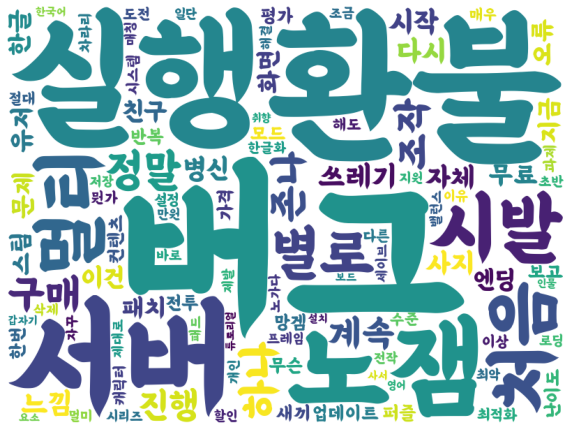

In [62]:
wordcloud = WordCloud(font_path="/content/drive/MyDrive/BMEULJIROTTF.ttf",
                     background_color='white',width=800, height=600)
#print(dict(tags))

cloud = wordcloud.generate_from_frequencies(dict(tags))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

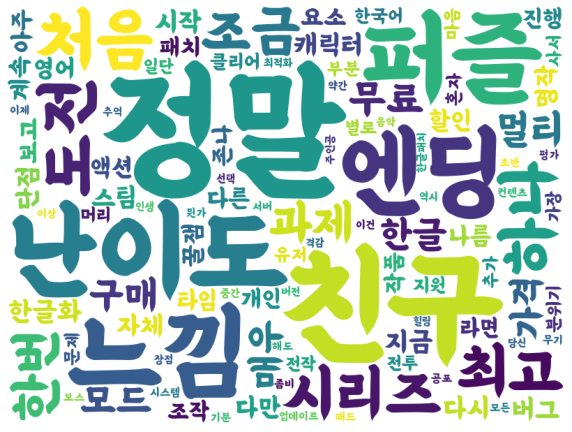

In [63]:
wordcloud1 = WordCloud(font_path="/content/drive/MyDrive/BMEULJIROTTF.ttf",
                     background_color='white',width=800, height=600)
#print(dict(tags1))

cloud1 = wordcloud1.generate_from_frequencies(dict(tags1))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud1)
plt.show()

# **모델 학습**

In [64]:
df.head()

,Label,Review,tokens
0,0,노래가 너무 적음,"[노래, 너무, 적음]"
1,0,돌겠네 진짜 황숙아 어크 공장 그만 돌려라 죽는다,"[돌겠네, 진짜, 황숙, 아, 어크, 공장, 그만, 돌려라, 죽는다]"
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험판, 막노동, 하는, 사람, 인데, 장비, 내, 사야, 돼, 뭐]"
3,1,차악차악차악 정말 이래서 왕국을 되찾을 수 있는거야,"[차악차악차악, 정말, 이래서, 왕국, 되찾을, 수, 있는거야]"
4,1,시간 때우기에 좋음 도전과제는 시간이면 다 깰 수 있어요,"[시간, 때우기에, 좋음, 도전, 과제, 시간, 이면, 깰, 수, 있어요]"


In [65]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)
train.shape, test.shape

((79953, 3), (19989, 3))

In [66]:
X_train = train['tokens'].values
y_train = train['Label'].values
X_test= test['tokens'].values
y_test = test['Label'].values

**정수 인코딩**

In [67]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [76]:
words_limit = 2 
total_words = len(tokenizer.word_index) # The number of words
rare_words = 0 # Count the number of words appear less than threshold
whole_freq = 0 # Total frequency of all words in the train set
rare_freq = 0 # The sum of the frequency of appearance of words less than threshold

for key, value in tokenizer.word_counts.items():
    whole_freq = whole_freq + value

    # If the frequency of words appearing is less than threshold,
    if(value < words_limit):
        rare_words = rare_words + 1
        rare_freq = rare_freq + value

print('단어 집합 크기 :',total_words)
print('등장 빈도가 %s번 이하인 단어의 수: %s'%(words_limit - 1, rare_words))
print("단어 집합 내 사소하게 등장하는 단어의 비율:",(rare_words / total_words)*100)
print("총 등장 빈도에서 사소하게 단어 등장 빈도 비율:", (rare_freq / whole_freq)*100)

단어 집합 크기 : 72269
등장 빈도가 1번 이하인 단어의 수: 39440
단어 집합 내 사소하게 등장하는 단어의 비율: 54.573883684567384
총 등장 빈도에서 사소하게 단어 등장 빈도 비율: 3.704395964612875


In [77]:
word_size = total_words - rare_words + 2
print('단어 집합의 크기 :',word_size)

단어 집합의 크기 : 32831


In [78]:
tokenizer = Tokenizer(word_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [79]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 59
리뷰의 평균 길이 : 13.316335847310295


In [80]:
def review_length(max_len, list):
  count = 0
  for sentence in list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 데이터 내 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(list))*100))

In [81]:
max_len = 50
review_length(max_len, X_train)

전체 데이터 내 길이가 50 이하인 샘플의 비율: 99.98999412154642


In [82]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# **BiLSTM으로 감성분석 실시**

In [97]:
model = Sequential()
model.add(Embedding(word_size, 50))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks = [es, mc], batch_size = 256, validation_split = 0.2)

Epoch 1/10
248/250 [============================>.] - ETA: 0s - loss: 0.5366 - acc: 0.7334
Epoch 1: val_acc improved from -inf to 0.77975, saving model to model.h5
250/250 [==============================] - 7s 15ms/step - loss: 0.5359 - acc: 0.7337 - val_loss: 0.4673 - val_acc: 0.7798
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.4169 - acc: 0.8135
Epoch 2: val_acc improved from 0.77975 to 0.78438, saving model to model.h5
250/250 [==============================] - 3s 12ms/step - loss: 0.4169 - acc: 0.8135 - val_loss: 0.4611 - val_acc: 0.7844
Epoch 3/10
246/250 [============================>.] - ETA: 0s - loss: 0.3820 - acc: 0.8330
Epoch 3: val_acc improved from 0.78438 to 0.78738, saving model to model.h5
250/250 [==============================] - 3s 11ms/step - loss: 0.3828 - acc: 0.8325 - val_loss: 0.4599 - val_acc: 0.7874
Epoch 4/10
245/250 [============================>.] - ETA: 0s - loss: 0.3605 - acc: 0.8442
Epoch 4: val_acc did not improve from 0.78738

In [91]:
seed = 42
np.random.seed(seed)

In [93]:
def create_model():
    model = Sequential()
    model.add(Embedding(word_size, 50))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(1, activation='sigmoid'))

    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3)
    mc = ModelCheckpoint('model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [94]:
model = KerasClassifier(build_fn = create_model, epochs = 10, batch_size = 16, verbose=0)
kfold = KFold(n_splits=2, shuffle=True, random_state=seed) 
results = cross_val_score(model, X_train, y_train, cv=kfold)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [95]:
results 

array([0.76836681, 0.76838601])

In [96]:
np.mean(results)

0.7683764100074768

최종 **cross validation score** 는 **0.768**

In [98]:
loaded_model = load_model('model.h5')
print("test accuracy: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

625/625 [==============================] - 3s 4ms/step - loss: 0.4496 - acc: 0.7915
test accuracy: 0.7915


# **실제 리뷰 예측해보기**

In [99]:
def predict(review):
  review = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', review)
  review = okt.morphs(review) # 토큰화
  review = [word for word in review if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([review]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("이 리뷰는 {:.2f}% 의 확률로 긍정적인 리뷰입니다.".format(score * 100))
  else:
    print("이 리뷰는 {:.2f}% 의 확률로 부정적인 리뷰입니다.".format((1 - score) * 100))

**스팀에서 올해의 게임 상을 수상한 Biohazard Village의 리뷰를 사용해 보겠습니다.**

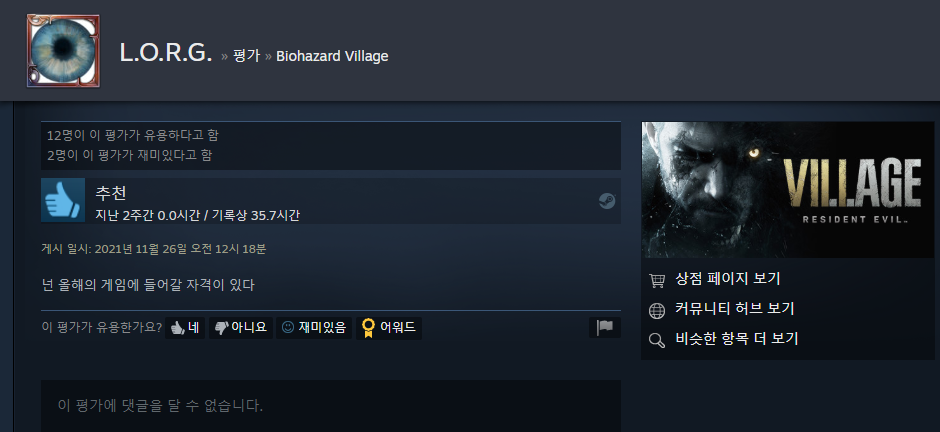

In [100]:
predict('넌 올해의 게임에 들어갈 자격이 있다')

이 리뷰는 93.80% 의 확률로 긍정적인 리뷰입니다.


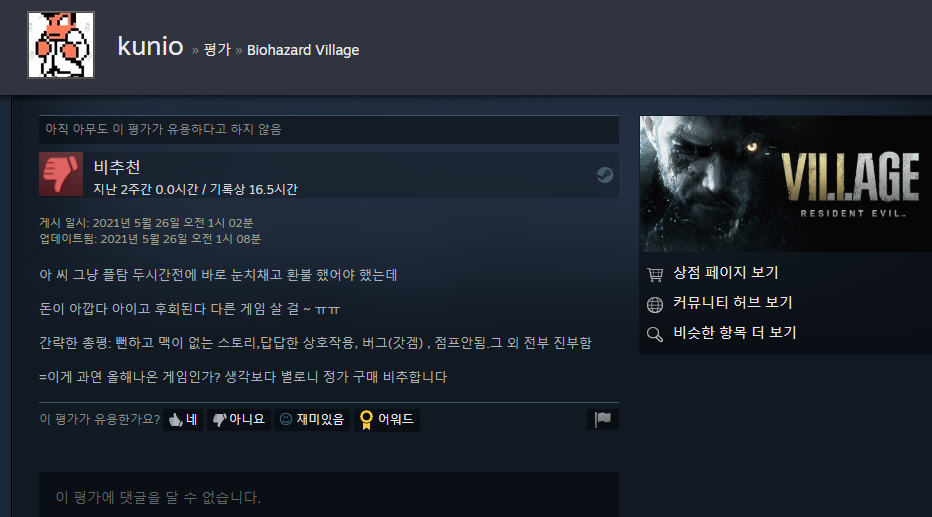

In [101]:
predict('아 씨 그냥 플탐 두시간전에 바로 눈치채고 환불 했어야 했는데 돈이 아깝다 아이고 후회된다 다른 게임 살 걸 ~ ㅠㅠ 간략한 총평: 뻔하고 맥이 없는 스토리,답답한 상호작용, 버그(갓겜) , 점프안됨.그 외 전부 진부함 이게 과연 올해나온 게임인가? 생각보다 별로니 정가 구매 비추합니다')

이 리뷰는 97.78% 의 확률로 부정적인 리뷰입니다.
